In [1]:
import string, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import jieba
import operator
import zhconv

import warnings
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')
from gensim.models import Word2Vec

from keras.preprocessing import sequence
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

Using TensorFlow backend.


In [2]:
from collections import Counter

In [3]:
comments_path = r'../dataset/movie_comments.csv'
model_path = r'../models/zhwiki.50d.word2vec'

# ÂΩ±ËØÑÊï∞ÊçÆ

In [4]:
comments = pd.read_csv(comments_path, low_memory=False)
comments.head(10)

id                                        link name  \
0   1  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   
1   2  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   
2   3  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   
3   4  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   
4   5  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   
5   6  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   
6   7  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   
7   8  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   
8   9  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   
9  10  https://movie.douban.com/subject/26363254/  ÊàòÁãº2   

                                             comment star  
0                                 Âê¥‰∫¨ÊÑèÊ∑´Âà∞‰∫ÜËÑëÊÆãÁöÑÂú∞Ê≠•ÔºåÁúã‰∫ÜÊÅ∂ÂøÉÊÉ≥Âêê    1  
1  È¶ñÊò†Á§ºÁúãÁöÑ„ÄÇÂ§™ÊÅêÊÄñ‰∫ÜËøô‰∏™ÁîµÂΩ±Ôºå‰∏çËÆ≤ÈÅìÁêÜÁöÑÔºåÂÆåÂÖ®Â∞±ÊòØÂê¥‰∫¨Âú®ÂÆûÁé∞‰ªñËøô‰∏™Â∞èÁ≤âÁ∫¢ÁöÑËã±ÈõÑÊ¢¶„ÄÇÂêÑÁßçË£ÖÂ§áËΩÆ...    2  
2  Âê¥‰∫¨ÁöÑÁÇí‰ΩúÊ∞¥Âπ≥‰∏çËæìÂÜØÂ∞èÂàöÔºå‰ΩÜÂ∞èÂàöËá≥Â∞ë‰∏ç‰ºöÁî®‰∏ªÊóãÂæãÊù•ÁÇí‰Ωú‚Ä¶Âê¥‰∫¨ËÆ©‰∫∫Áúã‰∫Ü‰∏çËàíÊúçÔºå‰∏∫‰∫Ü‰∏ªÊóãÂæãËÄå‰∏ªÊóã...    2  
3                      Âá≠ËâØÂøÉËØ¥ÔºåÂ•ΩÁúãÂà∞‰∏çÂÉè„ÄäÊàòÁãº1„ÄãÁöÑÁª≠ÈõÜÔºåÂÆåËôê„ÄäÊπÑÂÖ¨Ê≤≥Ë°åÂä®„Äã„ÄÇ    4  
4                                               ‰∏≠‰∫åÂæóÂæà    1  
5                        ‚ÄúÁäØÊàë‰∏≠ÂçéËÄÖÔºåËôΩËøúÂøÖËØõ‚ÄùÔºåÂê¥‰∫¨ÊØîËøôÂè•ËØùËøòË¶ÅÊÑèÊ∑´‰∏ÄÁôæÂÄç„ÄÇ    1  
6                                  ËÑëÂ≠êÊòØ‰∏™Â•Ω‰∏úË•øÔºåÂ∏åÊúõÁºñÂâß‰ª¨ÈÉΩËÉΩÊúâ„ÄÇ    2  
7  ‰∏âÊòüÂçäÔºåÂÆûÊâìÂÆûÁöÑ7ÂàÜ„ÄÇÁ¨¨‰∏ÄÈõÜÂú®Áà±ÂõΩ‰∏ªÊóãÂæãÂÜÖÈÉ®ÂÅöÁùÄÂêÑÁßçÁΩÆÊç¢‰∏éËæÉÂä≤Ôºå‰ΩÜÁ¨¨‰∫åÈõÜÊâçÁúüÊ≠£ÊòæÈú≤Âê¥‰∫¨ÁöÑÈáéÂøÉ...    4  
8  ÂºÄÁØáÈïøÈïúÂ§¥ÊÉäÈô©Â§ßÊ∞îÂºï‰∫∫ÂÖ•ËÉú ÁªìÂêà‰∫ÜÊ∞¥Âπ≥‰∏ç‰øóÁöÑÂø´Ââ™‰∏ãÂÆûÊâìÂÆûÁöÑÁúüÂàÄÁúüÊû™ ËÆ©‰∫∫‰∏çÁ¶ÅÁÉ≠Ë°ÄÊ≤∏ËÖæ ÁâπÂà´Âºπ...    4  
9  15/100Âê¥‰∫¨ÁöÑÂÜ∑Â≥∞Âú®ËøôÈÉ®ÈáåÂç≥ÂÉèÊàêÈæôÔºåÂèàÂÉèÊù∞Ê£ÆÊñØÂù¶Ê£ÆÔºå‰ΩÜ‰ΩìÂà∂Â§ñÁöÑÂêåÁ±ªÂûãÁîµÂΩ±Ôºå‰∏ªËßíÊÄªÊòØ‰ª£Ë°®‰∏™...    1

In [5]:
comments.drop(['id','link','name'], axis=1, inplace=True)
print(comments.info())
comments.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261497 entries, 0 to 261496
Data columns (total 2 columns):
comment    261495 non-null object
star       261497 non-null object
dtypes: object(2)
memory usage: 4.0+ MB
None


comment star
0                                 Âê¥‰∫¨ÊÑèÊ∑´Âà∞‰∫ÜËÑëÊÆãÁöÑÂú∞Ê≠•ÔºåÁúã‰∫ÜÊÅ∂ÂøÉÊÉ≥Âêê    1
1  È¶ñÊò†Á§ºÁúãÁöÑ„ÄÇÂ§™ÊÅêÊÄñ‰∫ÜËøô‰∏™ÁîµÂΩ±Ôºå‰∏çËÆ≤ÈÅìÁêÜÁöÑÔºåÂÆåÂÖ®Â∞±ÊòØÂê¥‰∫¨Âú®ÂÆûÁé∞‰ªñËøô‰∏™Â∞èÁ≤âÁ∫¢ÁöÑËã±ÈõÑÊ¢¶„ÄÇÂêÑÁßçË£ÖÂ§áËΩÆ...    2
2  Âê¥‰∫¨ÁöÑÁÇí‰ΩúÊ∞¥Âπ≥‰∏çËæìÂÜØÂ∞èÂàöÔºå‰ΩÜÂ∞èÂàöËá≥Â∞ë‰∏ç‰ºöÁî®‰∏ªÊóãÂæãÊù•ÁÇí‰Ωú‚Ä¶Âê¥‰∫¨ËÆ©‰∫∫Áúã‰∫Ü‰∏çËàíÊúçÔºå‰∏∫‰∫Ü‰∏ªÊóãÂæãËÄå‰∏ªÊóã...    2
3                      Âá≠ËâØÂøÉËØ¥ÔºåÂ•ΩÁúãÂà∞‰∏çÂÉè„ÄäÊàòÁãº1„ÄãÁöÑÁª≠ÈõÜÔºåÂÆåËôê„ÄäÊπÑÂÖ¨Ê≤≥Ë°åÂä®„Äã„ÄÇ    4
4                                               ‰∏≠‰∫åÂæóÂæà    1
5                        ‚ÄúÁäØÊàë‰∏≠ÂçéËÄÖÔºåËôΩËøúÂøÖËØõ‚ÄùÔºåÂê¥‰∫¨ÊØîËøôÂè•ËØùËøòË¶ÅÊÑèÊ∑´‰∏ÄÁôæÂÄç„ÄÇ    1
6                                  ËÑëÂ≠êÊòØ‰∏™Â•Ω‰∏úË•øÔºåÂ∏åÊúõÁºñÂâß‰ª¨ÈÉΩËÉΩÊúâ„ÄÇ    2
7  ‰∏âÊòüÂçäÔºåÂÆûÊâìÂÆûÁöÑ7ÂàÜ„ÄÇÁ¨¨‰∏ÄÈõÜÂú®Áà±ÂõΩ‰∏ªÊóãÂæãÂÜÖÈÉ®ÂÅöÁùÄÂêÑÁßçÁΩÆÊç¢‰∏éËæÉÂä≤Ôºå‰ΩÜÁ¨¨‰∫åÈõÜÊâçÁúüÊ≠£ÊòæÈú≤Âê¥‰∫¨ÁöÑÈáéÂøÉ...    4
8  ÂºÄÁØáÈïøÈïúÂ§¥ÊÉäÈô©Â§ßÊ∞îÂºï‰∫∫ÂÖ•ËÉú ÁªìÂêà‰∫ÜÊ∞¥Âπ≥‰∏ç‰øóÁöÑÂø´Ââ™‰∏ãÂÆûÊâìÂÆûÁöÑÁúüÂàÄÁúüÊû™ ËÆ©‰∫∫‰∏çÁ¶ÅÁÉ≠Ë°ÄÊ≤∏ËÖæ ÁâπÂà´Âºπ...    4
9  15/100Âê¥‰∫¨ÁöÑÂÜ∑Â≥∞Âú®ËøôÈÉ®ÈáåÂç≥ÂÉèÊàêÈæôÔºåÂèàÂÉèÊù∞Ê£ÆÊñØÂù¶Ê£ÆÔºå‰ΩÜ‰ΩìÂà∂Â§ñÁöÑÂêåÁ±ªÂûãÁîµÂΩ±Ôºå‰∏ªËßíÊÄªÊòØ‰ª£Ë°®‰∏™...    1

#### Âà†Èô§ËØÑËÆ∫‰∏∫Á©∫ÁöÑË°å

In [6]:
comments = comments.dropna()
print(comments.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261495 entries, 0 to 261496
Data columns (total 2 columns):
comment    261495 non-null object
star       261495 non-null object
dtypes: object(2)
memory usage: 6.0+ MB
None


#### Âà†Èô§ËØÑÂàÜ‰∏ç‰∏∫Êï∞ÂÄºÁöÑË°å

In [7]:
comments = comments[comments['star'].isin(['1', '2', '3', '4', '5'])]
print(comments.info())
comments['star'] = comments['star'].astype('int')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261494 entries, 0 to 261496
Data columns (total 2 columns):
comment    261494 non-null object
star       261494 non-null object
dtypes: object(2)
memory usage: 6.0+ MB
None


#### Êü•ÁúãËØÑÂàÜÂàÜÊï∞ÂàÜÂ∏É:
- ‰∏çÂêåÁ±ªËØÑÂàÜÁöÑÂàÜÂ∏ÉÊØîËæÉ‰∏çÂùáÂåÄÔºåÁâπÂà´ÊòØ 1„ÄÅ2 ÂàÜ
- **todoÔºöÂ§ÑÁêÜËøôÁßç‰∏çÂπ≥Ë°°**

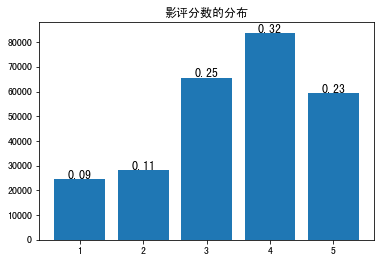

In [8]:
x = np.arange(1,6)
nums = [len(comments[comments['star']==i]) for i in x]

def plot_score_distribution(x, nums):
    plt.bar(x, nums)
   
    plt.title('ÂΩ±ËØÑÂàÜÊï∞ÁöÑÂàÜÂ∏É')
    for x,y in zip(x,nums):
        plt.text(x,y+100,round(y/sum(nums),2),ha='center',fontsize=12)
    plt.show()
    
plot_score_distribution(x, nums) 

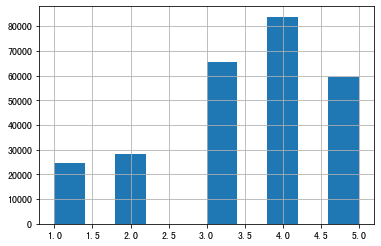

In [9]:
comments['star'].hist()

#### ÊñáÊú¨È¢ÑÂ§ÑÁêÜ
- Âà†Èô§Á¨¶Âè∑
- ÁπÅ‰ΩìËΩ¨ÁÆÄ‰Ωì
- ÂàÜËØçÂêé‰ª•Á©∫Ê†ºËøûÊé•
- Ëã±ÊñáÂ§ßÂÜôËΩ¨Â∞èÂÜô

In [10]:
punct = r"Ôºå„ÄÇÔºÅÔºü„ÄÅÔºõÔºö‚Äú‚Äù\nÔºÇÔºÉÔºÑÔºÖÔºÜÔºáÔºàÔºâÔºäÔºãÔºçÔºèÔºúÔºùÔºûÔº†ÔºªÔººÔºΩÔºæÔºøÔΩÄÔΩõÔΩúÔΩùÔΩûÔΩüÔΩ†ÔΩ¢ÔΩ£ÔΩ§„ÄÉ„Ää„Äã„Äå„Äç„Äé„Äè„Äê„Äë„Äî„Äï„Äñ„Äó„Äò„Äô„Äö„Äõ„Äú„Äù„Äü„Ä∞„Äæ„Äø‚Äì‚Äî‚Äõ‚Äû‚Äü‚Ä¶‚ÄßÔπè‚òÖ‚òÜ‚Ä¢‚Üí‚ñΩ"

In [11]:
def clean_special_chars(text):
    re_tok = re.compile(f'([{string.punctuation}{punct}])')
    return re_tok.sub(r' ', text)

In [12]:
def simplify(text):
    return zhconv.convert(text, 'zh-cn')

In [13]:
def cut_join(text):
    space = ' '
    words = jieba.cut(text)
    return space.join([w.lower() for w in words if not w.isspace()])

In [14]:
def preprocess(text):
    text = clean_special_chars(text)
    text = simplify(text)
    text = cut_join(text)
    return text

In [15]:
comments['cleaned_comment'] = comments['comment'].apply(preprocess)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yangbin\AppData\Local\Temp\jieba.cache
Loading model cost 1.140 seconds.
Prefix dict has been built succesfully.


In [18]:
comments['cleaned_comment'].head(10)

0                         Âê¥‰∫¨ ÊÑèÊ∑´ Âà∞ ‰∫Ü ËÑëÊÆã ÁöÑ Âú∞Ê≠• Áúã ‰∫Ü ÊÅ∂ÂøÉ ÊÉ≥ Âêê
1    È¶ñÊò†Á§º Áúã ÁöÑ Â§™ ÊÅêÊÄñ ‰∫Ü Ëøô‰∏™ ÁîµÂΩ± ‰∏çËÆ≤ÈÅìÁêÜ ÁöÑ ÂÆåÂÖ® Â∞±ÊòØ Âê¥‰∫¨ Âú® ÂÆûÁé∞ ‰ªñ Ëøô‰∏™...
2    Âê¥‰∫¨ ÁöÑ ÁÇí‰Ωú Ê∞¥Âπ≥ ‰∏çËæì ÂÜØÂ∞èÂàö ‰ΩÜÂ∞èÂàö Ëá≥Â∞ë ‰∏ç‰ºö Áî® ‰∏ªÊóãÂæã Êù• ÁÇí‰Ωú Âê¥‰∫¨ ËÆ© ‰∫∫ ...
3                     Âá≠ËâØÂøÉËØ¥ Â•Ω ÁúãÂà∞ ‰∏çÂÉè ÊàòÁãº 1 ÁöÑ Áª≠ÈõÜ ÂÆåËôê ÊπÑÂÖ¨Ê≤≥ Ë°åÂä®
4                                                ‰∏≠‰∫åÂæó Âæà
5                   ÁäØ Êàë ‰∏≠Âçé ËÄÖ ËôΩËøúÂøÖ ËØõ Âê¥‰∫¨ ÊØî ËøôÂè• ËØù ËøòË¶Å ÊÑèÊ∑´ ‰∏ÄÁôæÂÄç
6                            ËÑëÂ≠ê ÊòØ ‰∏™ Â•Ω ‰∏úË•ø Â∏åÊúõ ÁºñÂâß ‰ª¨ ÈÉΩ ËÉΩ Êúâ
7    ‰∏âÊòü Âçä ÂÆûÊâìÂÆû ÁöÑ 7 ÂàÜ Á¨¨‰∏ÄÈõÜ Âú® Áà±ÂõΩ ‰∏ªÊóãÂæã ÂÜÖÈÉ® ÂÅö ÁùÄ ÂêÑÁßç ÁΩÆÊç¢ ‰∏é ËæÉÂä≤ ...
8    ÂºÄÁØá ÈïøÈïúÂ§¥ ÊÉäÈô© Â§ßÊ∞î Âºï‰∫∫ÂÖ•ËÉú ÁªìÂêà ‰∫Ü Ê∞¥Âπ≥ ‰∏ç‰øó ÁöÑ Âø´ Ââ™‰∏ã ÂÆûÊâìÂÆû ÁöÑ ÁúüÂàÄÁúüÊû™...
9    15 100 Âê¥‰∫¨ ÁöÑ ÂÜ∑Â≥∞ Âú® ËøôÈÉ® Èáå Âç≥ ÂÉè ÊàêÈæô Âèà ÂÉèÊù∞ Ê£ÆÊñØÂù¶ Ê£Æ ‰ΩÜ ‰ΩìÂà∂ Â§ñ...
Name

#### Êü•ÁúãÂΩ±ËØÑÁöÑÂ≠óÊï∞ÂàÜÂ∏É
- 5% ÁöÑÂΩ±ËØÑÂ≠óÊï∞Â∞ë‰∫é 3 ‰∏™ÔºåÂà†Èô§Ëøô‰∫õÊï∞ÊçÆÔºõÂà†Èô§ÂêéÂØπÁ±ªÂà´ÂàÜÂ∏ÉÊó†ÂΩ±Âìç
- **todoÔºöÊõ¥Â•ΩÁöÑÊñπÊ≥ïÂ§ÑÁêÜ‰∏çÂêåÂΩ±ËØÑÁöÑËøôÁßçÂ≠óÊï∞Â∑ÆÂà´**

In [19]:
comments['comment_length'] = comments['comment'].apply(len).astype('int')

In [20]:
min_ = comments['comment_length'].min()
max_ = comments['comment_length'].max()
median = comments['comment_length'].median()
mean = comments['comment_length'].mean()
mode = comments['comment_length'].mode()[0]
print(min_, max_, median, mean, mode)

1 4247 19.0 34.62489770319778 7


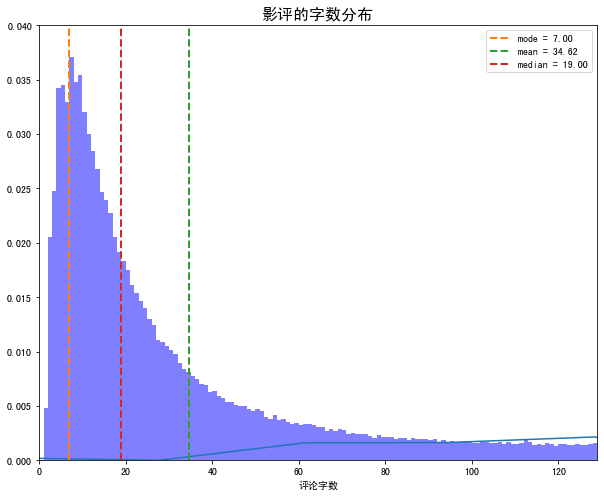

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
sn.distplot(comments['comment_length'], bins=comments['comment_length'].max(),
            hist_kws={"alpha": 0.5, "color": "blue"}, ax=ax)
ax.set_xlim(left=0, right=np.percentile(comments['comment_length'], 95))
ax.set_xlabel('ËØÑËÆ∫Â≠óÊï∞')
ymax = 0.04
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=2)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=2)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=2)
ax.set_title('ÂΩ±ËØÑÁöÑÂ≠óÊï∞ÂàÜÂ∏É', fontsize=16)
plt.legend()
plt.show()

In [22]:
np.percentile(comments['comment_length'], 5)

3.0

In [23]:
comments = comments[comments['comment_length']>3]
print(comments.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248396 entries, 0 to 261496
Data columns (total 4 columns):
comment            248396 non-null object
star               248396 non-null int32
cleaned_comment    248396 non-null object
comment_length     248396 non-null int32
dtypes: int32(2), object(2)
memory usage: 7.6+ MB
None


**Â≠óÊï∞ÊúÄÂ∞ëÔºà4‰∏™Â≠óÔºâÁöÑËØÑËÆ∫ÁöÑÁöÑËØÑÂàÜÂàÜÂ∏É**

In [24]:
len(comments[comments['comment_length']==4])

8947

D:\Program\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


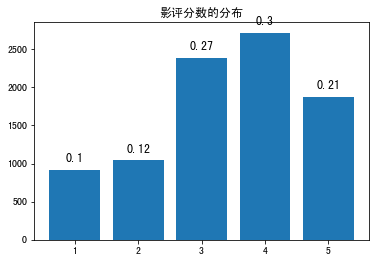

In [25]:
x = np.arange(1,6)
nums = [len(comments[comments['comment_length']==4][comments['star']==i]) for i in x]
plot_score_distribution(x, nums)

In [26]:
comments[comments['comment_length']==4][['comment','star']][:20]

comment  star
4      ‰∏≠‰∫åÂæóÂæà     1
67     3dÊâ£ÂàÜ     2
141    Áà±‰∏éÂùöÊåÅ     3
162    ÂãáÊï¢Èù¢ÂØπ     4
180    Âä±ÂøóÂ§ßÁâá     5
208    MITÔºü     4
220    MITÔºü     4
251    Âπ≥Ê∞ëÂä±Âøó     4
258    Âπ≥Ê∞ëÂä±Âøó     4
265    Ëã¶Â∞ΩÁîòÊù•     4
268    ÂæàÂ•ΩÁúã„ÄÇ     5
303    ÂñúÊ¨¢ÂñúÊ¨¢     5
330    ÂæàÁ´ãÂøóÂïä     5
445    Â∞ºÁéõËøòÈí±     1
459    Â∞ºÁéõËøòÈí±     1
475    Â∞ºÁéõËøòÈí±     1
484    Ë¥üÂàÜÊªöÁ≤ó     1
494    Â∞ºÁéõËøòÈí±     1
503    Ë¥üÂàÜÊªöÁ≤ó     1
508    Â∞ºÁéõËøòÈí±     1

# Â∞ÜÊñáÊú¨ËΩ¨Êç¢ÊàêÂêëÈáè

#### ËØçÂêëÈáè
- ‰ΩøÁî®‰∏≠ÊñáÁª¥Âü∫ÁöÑÈ¢ÑËÆ≠ÁªÉËØçÂêëÈáè

In [27]:
model = Word2Vec.load(model_path)
wv = model.wv
del model

D:\Program\Anaconda3\envs\nlp\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [28]:
len(wv.vocab)

845989

In [29]:
wv.most_similar(['Âê¥‰∫¨'])

[('Âº†ÈùôÂàù', 0.8863259553909302),
 ('ÂàòÁÉ®', 0.8568055629730225),
 ('ÂªñÂá°', 0.8530554175376892),
 ('Âº†Èúá', 0.8500816822052002),
 ('Âº†Ê∂µ‰∫à', 0.8481923341751099),
 ('ËÉ°ÂÜõ', 0.8465080857276917),
 ('ÊÆµÂ•ïÂÆè', 0.8462876081466675),
 ('ÈªÑËΩ©', 0.844296932220459),
 ('ÈªÑÊ∏§', 0.8436167240142822),
 ('Âñª‰∫¢', 0.8426705598831177)]

In [30]:
index = wv.index2word.index('Âê¥‰∫¨')
index

48404

#### ÂàõÂª∫ËØçÊ±áË°®

In [96]:
def build_vocab(texts):
    vocab = {}
    for t in texts:
        words = t.strip().split()
        for word in words:
            if word != 'unkown':
                vocab[word] = vocab.get(word, 0) + 1
    return vocab

In [35]:
vocab = build_vocab(comments['cleaned_comment'])
vocab

{'Âê¥‰∫¨': 279,
 'ÊÑèÊ∑´': 279,
 'Âà∞': 10358,
 '‰∫Ü': 102050,
 'ËÑëÊÆã': 316,
 'ÁöÑ': 328370,
 'Âú∞Ê≠•': 197,
 'Áúã': 34252,
 'ÊÅ∂ÂøÉ': 922,
 'ÊÉ≥': 7471,
 'Âêê': 565,
 'È¶ñÊò†Á§º': 42,
 'Â§™': 12975,
 'ÊÅêÊÄñ': 596,
 'Ëøô‰∏™': 10269,
 'ÁîµÂΩ±': 34593,
 '‰∏çËÆ≤ÈÅìÁêÜ': 8,
 'ÂÆåÂÖ®': 4152,
 'Â∞±ÊòØ': 14014,
 'Âú®': 31161,
 'ÂÆûÁé∞': 270,
 '‰ªñ': 10655,
 'Â∞è': 6647,
 'Á≤âÁ∫¢': 39,
 'Ëã±ÈõÑ': 1705,
 'Ê¢¶': 871,
 'ÂêÑÁßç': 3136,
 'Ë£ÖÂ§á': 80,
 'ËΩÆÁï™': 21,
 '‰∏äÂú∫': 17,
 'ËßÜ': 29,
 'Áâ©ÁêÜ': 63,
 'ÈÄªËæë': 1414,
 '‰∫é': 1783,
 '‰∏çÈ°æ': 57,
 '‰∏çÂæó‰∏ç': 670,
 'ËØ¥': 11123,
 'ÊúâÈí±': 205,
 'Áúü': 5180,
 'Â•Ω': 22827,
 'ÈöèÊÑè': 170,
 'ËÉ°Èóπ': 45,
 'ÁÇí‰Ωú': 70,
 'Ê∞¥Âπ≥': 819,
 '‰∏çËæì': 48,
 'ÂÜØÂ∞èÂàö': 266,
 '‰ΩÜÂ∞èÂàö': 1,
 'Ëá≥Â∞ë': 912,
 '‰∏ç‰ºö': 2684,
 'Áî®': 3944,
 '‰∏ªÊóãÂæã': 923,
 'Êù•': 5251,
 'ËÆ©': 13704,
 '‰∫∫': 24157,
 '‰∏ç': 28318,
 'ËàíÊúç': 607,
 '‰∏∫‰∫Ü': 3506,
 'ËÄå': 6535,
 'ÁÖΩÊÉÖ': 1171,
 'ËßâÂæó': 8878,
 'ÊòØ': 72707,
 '‰∏™': 6664,
 'Â§ß': 5911,
 'ÂÅö‰Ωú':

In [36]:
print("ËØÑËÆ∫ÊÄªÂçïËØçÊï∞Ôºö{}ÔºõËØçÊ±áË°®ÂçïËØç‰∏™Êï∞Ôºö{}".format(sum(vocab.values()), len(vocab)))

ËØÑËÆ∫ÊÄªÂçïËØçÊï∞Ôºö4558546ÔºõËØçÊ±áË°®ÂçïËØç‰∏™Êï∞Ôºö139721


In [97]:
word2index = {'unkown':0}
for word,_ in vocab.items():
    word2index[word] = len(word2index)

In [98]:
word2index

{'unkown': 0,
 'Âê¥‰∫¨': 1,
 'ÊÑèÊ∑´': 2,
 'Âà∞': 3,
 '‰∫Ü': 4,
 'ËÑëÊÆã': 5,
 'ÁöÑ': 6,
 'Âú∞Ê≠•': 7,
 'Áúã': 8,
 'ÊÅ∂ÂøÉ': 9,
 'ÊÉ≥': 10,
 'Âêê': 11,
 'È¶ñÊò†Á§º': 12,
 'Â§™': 13,
 'ÊÅêÊÄñ': 14,
 'Ëøô‰∏™': 15,
 'ÁîµÂΩ±': 16,
 '‰∏çËÆ≤ÈÅìÁêÜ': 17,
 'ÂÆåÂÖ®': 18,
 'Â∞±ÊòØ': 19,
 'Âú®': 20,
 'ÂÆûÁé∞': 21,
 '‰ªñ': 22,
 'Â∞è': 23,
 'Á≤âÁ∫¢': 24,
 'Ëã±ÈõÑ': 25,
 'Ê¢¶': 26,
 'ÂêÑÁßç': 27,
 'Ë£ÖÂ§á': 28,
 'ËΩÆÁï™': 29,
 '‰∏äÂú∫': 30,
 'ËßÜ': 31,
 'Áâ©ÁêÜ': 32,
 'ÈÄªËæë': 33,
 '‰∫é': 34,
 '‰∏çÈ°æ': 35,
 '‰∏çÂæó‰∏ç': 36,
 'ËØ¥': 37,
 'ÊúâÈí±': 38,
 'Áúü': 39,
 'Â•Ω': 40,
 'ÈöèÊÑè': 41,
 'ËÉ°Èóπ': 42,
 'ÁÇí‰Ωú': 43,
 'Ê∞¥Âπ≥': 44,
 '‰∏çËæì': 45,
 'ÂÜØÂ∞èÂàö': 46,
 '‰ΩÜ': 47,
 'Â∞èÂàö': 48,
 'Ëá≥Â∞ë': 49,
 '‰∏ç‰ºö': 50,
 'Áî®': 51,
 '‰∏ªÊóãÂæã': 52,
 'Êù•': 53,
 'ËÆ©': 54,
 '‰∫∫': 55,
 '‰∏ç': 56,
 'ËàíÊúç': 57,
 '‰∏∫‰∫Ü': 58,
 'ËÄå': 59,
 'ÁÖΩÊÉÖ': 60,
 'ËßâÂæó': 61,
 'ÊòØ': 62,
 '‰∏™': 63,
 'Â§ß': 64,
 'ÂÅö‰Ωú': 65,
 'Ë∞éË®Ä': 66,
 'ÂÆ∂': 67,
 'Êõ¥Êñ∞': 68,
 'ÁâáÂ≠ê': 69,
 'Êï¥‰Ωì': 70,
 '‰∏çÂ¶Ç

#### ËØÑËÆ∫‰∏≠Ê≤°ÊúâËØçÂêëÈáè‰∏≠ÁöÑËØç
- Ëß£ÂÜ≥Êé™ÊñΩÔºöÁªßÁª≠ÂàÜËØç
- ÊãºÂÜôÁ∫†ÈîôÔºöÂ¶Ç‚ÄúÈ∏°ÂÜª‚Äù--> ‚ÄúÊøÄÂä®‚Äù

In [39]:
def check_coverage(vocab, wv):
    known_words = {}
    unknown_words = {}
    no_known_words = 0
    no_unknown_words = 0
    for word in vocab:
        try:
            known_words[word] = wv[word]
            no_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            no_unknown_words += vocab[word]
    print('ËØçÊ±áË°®‰∏≠ {:.2%} ÁöÑÂçïËØçÊúâËØçÂêëÈáè'.format(len(known_words) / len(vocab)))
    print('ËØÑËÆ∫ÁöÑÊâÄÊúâÂçïËØç‰∏≠ {:.2%} ÁöÑÂçïËØçÊúâËØçÂêëÈáè'.format(no_known_words / (no_known_words + no_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    return unknown_words

In [40]:
unknown_words = check_coverage(vocab, wv)

ËØçÊ±áË°®‰∏≠ 69.33% ÁöÑÂçïËØçÊúâËØçÂêëÈáè
ËØÑËÆ∫ÁöÑÊâÄÊúâÂçïËØç‰∏≠ 97.05% ÁöÑÂçïËØçÊúâËØçÂêëÈáè


In [42]:
len(unknown_words)

42851

In [41]:
sorted(unknown_words, key=lambda w:len(w[0]), reverse=True)[:50]

[('ahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhotdwarvesatyourservice',
  1),
 ('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah',
  1),
 ('hiusjufbjijhjjsfightdjsiosnwnbombsisjwnexplosionwhshbdbwwhatfuckjusthappenddhsjsndhdjfighrekizjekilldbiejsshotdhsjsnthatbitchsjdjjffuckjejsh',
  1),
 ('bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbest',
  2),
 ('bce43fd38b93b6c518d056245a8a4de28880c502e41eebc1978142bcb20fadc9bc54d7cbb6a0',
  1),
 ('prprprprprprprprprprprprprprprprprprprprpr', 2),
 ('97db28f635ac65285bac7790ca7a36ca2234679201', 1),
 ('3a3e3c800a74582d2295df84c6624848bd6ed54a', 2),
 ('4ee833da28c2d1

In [44]:
sorted(unknown_words, key=lambda w:w[1], reverse=True)[:50]

[('2', 3789),
 ('3', 3620),
 ('1', 3510),
 ('5', 3353),
 ('4', 2237),
 ('7', 1719),
 ('8', 1516),
 ('10', 1476),
 ('6', 1216),
 ('3d', 1055),
 ('0', 919),
 ('9', 822),
 ('20', 660),
 ('12', 535),
 ('90', 501),
 ('30', 445),
 ('Âä†‰∏ÄÊòü', 443),
 ('11', 432),
 ('ÊòüÁªô', 420),
 ('80', 413),
 ('‰∏ÄËà¨Ëà¨', 410),
 ('‚ãØ', 386),
 ('15', 341),
 ('100', 340),
 ('007', 322),
 ('13', 315),
 ('50', 272),
 ('2016', 269),
 ('2008', 268),
 ('2012', 260),
 ('2015', 249),
 ('2014', 242),
 ('2013', 239),
 ('14', 236),
 ('‚Äô', 233),
 ('18', 228),
 ('17', 226),
 ('60', 223),
 ('cctv6', 216),
 ('21', 213),
 ('2010', 210),
 ('Â§™Ëµû', 209),
 ('‚ïØ', 205),
 ('2017', 205),
 ('70', 204),
 ('Ôø£', 203),
 ('‚Äò', 202),
 ('2009', 201),
 ('Ê≤°Âä≤', 200),
 ('‚ï∞', 198)]

In [50]:
'2' in wv

False

##### Ê≤°ÊúâËØçÂêëÈáèÁöÑÊ±âËØ≠Áü≠ËØ≠

In [51]:
def is_chinese(str):
    for s in str:
        if  u'\u4e00' <= s <= u'\u9fff':
            return True
    return False

In [52]:
is_chinese('ÂêõÂ≠ê‰πã‰∫§Ê∑°Â¶ÇÊ∞¥')

True

In [53]:
unknown_chinese=[(w,c) for w, c in unknown_words if is_chinese(w)]
len(unknown_chinese)

37180

In [54]:
sorted(unknown_chinese, key=lambda w:len(w[0]), reverse=True)[:10]

[('‰πùÁôæÂÖ≠ÂçÅ‰∏áÂπ≥ÊñπÂÖ¨Èáå', 1),
 ('‰∏à‰∫åÂíåÂ∞öÊë∏‰∏çÁùÄÂ§¥ËÑë', 1),
 ('Á©∑‰∫∫ÁöÑÂ≠©Â≠êÊó©ÂΩìÂÆ∂', 1),
 ('ÁôæÂ∞∫Á´øÂ§¥Êõ¥Ëøõ‰∏ÄÊ≠•', 1),
 ('ÂÖ´‰ªôËøáÊµ∑ÂêÑÊòæÁ•ûÈÄö', 1),
 ('ÂêõÂ≠ê‰πã‰∫§Ê∑°Â¶ÇÊ∞¥', 10),
 ('Ê†ëÊ¨≤ÈùôËÄåÈ£é‰∏çÊ≠¢', 7),
 ('Á´πÁØÆÊâìÊ∞¥‰∏ÄÂú∫Á©∫', 7),
 ('Â§©ÁîüÊàëÊùêÂøÖÊúâÁî®', 4),
 ('Â§©‰∏ã‰πåÈ∏¶‰∏ÄËà¨Èªë', 3)]

In [55]:
sorted(unknown_chinese, key=lambda w:w[1], reverse=True)[:10]

[('Âä†‰∏ÄÊòü', 443),
 ('ÊòüÁªô', 420),
 ('‰∏ÄËà¨Ëà¨', 410),
 ('Â§™Ëµû', 209),
 ('Ê≤°Âä≤', 200),
 ('Â∏¶ÊÑü', 177),
 ('Â∞øÁÇπ', 155),
 ('ËÑëÊÆãÁ≤â', 152),
 ('ÊÆãÁ≤â', 146),
 ('ÁúãÂæó‰∫∫', 146)]

- Ê≤°ÊúâËØçÂêëÈáèÁöÑÊ±âËØ≠Áü≠ËØ≠ÔºåÂâçÂêëÊúÄÂ§ßÂåπÈÖçÁªßÁª≠ÂàÜËØç

In [58]:
def cut(text):
    words = []
    while text:
        seg = text
        n = len(seg)
        for j in range(n, 0, -1):
            w = seg[:j]
            if w in wv:
                words.append(w)
                text = text[j:]
                break
            if len(w)==1 and not w.isspace():
                text = text[j:]
    return words

In [59]:
for w,_ in sorted(unknown_chinese, key=lambda w:len(w[0]), reverse=True)[:10]:
    print(cut(w))

['‰πùÁôæ', 'ÂÖ≠ÂçÅ‰∏á', 'Âπ≥ÊñπÂÖ¨Èáå']
['‰∏à‰∫å', 'ÂíåÂ∞ö', 'Êë∏‰∏çÁùÄÂ§¥ËÑë']
['Á©∑‰∫∫', 'ÁöÑ', 'Â≠©Â≠ê', 'Êó©', 'ÂΩìÂÆ∂']
['ÁôæÂ∞∫Á´øÂ§¥', 'Êõ¥Ëøõ‰∏ÄÊ≠•']
['ÂÖ´‰ªôËøáÊµ∑', 'ÂêÑÊòæÁ•ûÈÄö']
['ÂêõÂ≠ê‰πã‰∫§', 'Ê∑°Â¶ÇÊ∞¥']
['Ê†ë', 'Ê¨≤', 'Èùô', 'ËÄåÈ£é', '‰∏çÊ≠¢']
['Á´πÁØÆ', 'ÊâìÊ∞¥', '‰∏ÄÂú∫Á©∫']
['Â§©Áîü', 'ÊàëÊùê', 'ÂøÖÊúâÁî®']
['Â§©‰∏ã', '‰πåÈ∏¶', '‰∏ÄËà¨', 'Èªë']


In [60]:
for w,_ in sorted(unknown_chinese, key=lambda w:w[1], reverse=True)[:10]:
    print(cut(w))

['Âä†‰∏Ä', 'Êòü']
['Êòü', 'Áªô']
['‰∏ÄËà¨', 'Ëà¨']
['Â§™', 'Ëµû']
['Ê≤°', 'Âä≤']
['Â∏¶', 'ÊÑü']
['Â∞ø', 'ÁÇπ']
['ËÑëÊÆã', 'Á≤â']
['ÊÆã', 'Á≤â']
['ÁúãÂæó', '‰∫∫']


##### ÂÖ®Ëã±ÊñáÂ≠óÁ¨¶Áü≠ËØ≠

In [62]:
def is_string(str):
    for s in str:
        if s not in string.ascii_lowercase:
            return False
    return True

In [63]:
unknown_string=[(w,c) for w, c in unknown_words if is_string(w)]
len(unknown_string)

2306

In [64]:
unknown_string

[('dvdrip', 70),
 ('bdrip', 18),
 ('ccav', 17),
 ('bjiff', 15),
 ('hitchitsch', 15),
 ('btih', 15),
 ('johnnydepp', 14),
 ('jlo', 13),
 ('xxoo', 13),
 ('nnd', 13),
 ('willsmith', 12),
 ('xmen', 12),
 ('yyets', 12),
 ('mdzz', 12),
 ('kevinspacey', 10),
 ('exm', 10),
 ('clinteastwood', 10),
 ('mlgb', 10),
 ('happyending', 9),
 ('blabla', 9),
 ('prpr', 9),
 ('qwq', 9),
 ('tomhanks', 9),
 ('megryan', 8),
 ('cinematheque', 8),
 ('xddd', 8),
 ('jimcarrey', 8),
 ('dxy', 7),
 ('rylance', 7),
 ('woodyallen', 7),
 ('bluesliver', 7),
 ('robertdeniro', 7),
 ('congroo', 7),
 ('gscas', 7),
 ('jasonstatham', 7),
 ('quq', 7),
 ('balmes', 7),
 ('undatable', 6),
 ('undateable', 6),
 ('depressing', 6),
 ('kyxq', 6),
 ('amiable', 6),
 ('bingbong', 6),
 ('clotaire', 6),
 ('angelinajolie', 6),
 ('hughjackman', 6),
 ('qmdb', 6),
 ('timburton', 6),
 ('prevarticle', 6),
 ('maggieq', 6),
 ('nicolascage', 6),
 ('tnnd', 6),
 ('piapiapia', 6),
 ('vikander', 6),
 ('hanmeimei', 6),
 ('panzerlied', 5),
 ('agyness', 5

In [66]:
for w,_ in unknown_string[:10]:
    print(cut(w))

['dvd', 'rip']
['bdr', 'ip']
['cca', 'v']
['bji', 'ff']
['hitch', 'its', 'ch']
['bti', 'h']
['johnny', 'depp']
['jl', 'o']
['xxo', 'o']
['nn', 'd']


##### ÂÖ∂ÂÆÉ

In [49]:
unknown_others=list(set(unknown_words)-set(unknown_chinese)-set(unknown_string))
unknown_others

[('2728265', 1),
 ('5lbeyv5pz6qg', 2),
 ('333', 2),
 ('u7yg096tzk5o', 1),
 ('1200', 2),
 ('5278', 1),
 ('cespj5rjk', 1),
 ('‡∫∂', 2),
 ('8e', 2),
 ('20150228', 1),
 ('1vn', 1),
 ('1983', 15),
 ('Ã©', 10),
 ('20130908', 1),
 ('080101', 1),
 ('4000', 5),
 ('ending8', 1),
 ('grmad2vqr98', 2),
 ('4291588', 2),
 ('tt1590089', 1),
 ('3513717731', 1),
 ('765', 10),
 ('1030', 1),
 ('6296', 1),
 ('1190', 2),
 ('xmtg4nzc3ote2', 1),
 ('18x', 1),
 ('20170710', 1),
 ('tt0116455', 1),
 ('20170714', 1),
 ('t4c325b939', 1),
 ('2626', 1),
 ('mh370', 1),
 ('35', 57),
 ('27003912', 1),
 ('üê≤', 1),
 ('164184', 1),
 ('3105', 1),
 ('me109', 1),
 ('1970', 1),
 ('49', 20),
 ('1ge2qycv', 1),
 ('150328', 1),
 ('8067', 1),
 ('‚àë', 3),
 ('12232015', 1),
 ('120212', 1),
 ('2014may17', 1),
 ('Õ§', 1),
 ('8338', 1),
 ('20120821', 1),
 ('5cm', 1),
 ('20130227jtl', 1),
 ('Õà', 2),
 ('üêë', 1),
 ('197', 1),
 ('bwv106', 2),
 ('‚¨Ö', 2),
 ('666', 10),
 ('html5', 3),
 ('üí§', 4),
 ('k9c8cbdhnuue', 1),
 ('64', 23),
 (

In [50]:
cleaned_unknown={}
i = 0
for w,_ in unknown_words:
    # Âà†Èô§ÈáçÂ§çÂ≠óÊØç
    pat1 = re.compile(r"([a-z])(\1{3,})")
    # Âà†Èô§ÈáçÂ§çÁöÑÂ≠óÁ¨¶‰∏≤
    pat2 = re.compile(r"(\w+)(\1{2,}?)")
    t1 = pat1.sub(r"\1",w)
    t2 = pat1.sub(r"\1",w)
    if t1!=w:
        cleaned_unknown[w]=t1
    else:
        if t2!=w:
            cleaned_unknown[w]=t2

#### ÈáçÊñ∞Â§ÑÁêÜÊñáÊú¨

In [67]:
def cut_join(text):
    results = []
    space = ' '
    seg_list = jieba.cut(text)
    for w in seg_list:
        if w in wv:
            results.append(w)
        else:
            if is_chinese(w):
                words = cut(w)
                results.extend(words)
            elif is_string(w):
                words = cut(w)
                words = list(set(words))
                results.extend(words)
    return space.join(results)

In [68]:
list(jieba.cut('12abc43 ‰πùÁôæÂÖ≠ÂçÅ‰∏áÂπ≥ÊñπÂÖ¨Èáå pbocyq5ccfs woow'))

['12abc43', ' ', '‰πùÁôæÂÖ≠ÂçÅ‰∏áÂπ≥ÊñπÂÖ¨Èáå', ' ', 'pbocyq5ccfs', ' ', 'woow']

In [69]:
cut_join('12abc43 ‰πùÁôæÂÖ≠ÂçÅ‰∏áÂπ≥ÊñπÂÖ¨Èáå pbocyq5ccfs woow')

'‰πùÁôæ ÂÖ≠ÂçÅ‰∏á Âπ≥ÊñπÂÖ¨Èáå w woo'

In [70]:
comments['cleaned_comment'] = comments['comment'].apply(preprocess)

In [71]:
vocab = build_vocab(comments['cleaned_comment'])
vocab

{'Âê¥‰∫¨': 312,
 'ÊÑèÊ∑´': 279,
 'Âà∞': 10929,
 '‰∫Ü': 102423,
 'ËÑëÊÆã': 503,
 'ÁöÑ': 328489,
 'Âú∞Ê≠•': 199,
 'Áúã': 35779,
 'ÊÅ∂ÂøÉ': 924,
 'ÊÉ≥': 7766,
 'Âêê': 608,
 'È¶ñÊò†Á§º': 42,
 'Â§™': 15646,
 'ÊÅêÊÄñ': 596,
 'Ëøô‰∏™': 10269,
 'ÁîµÂΩ±': 34739,
 '‰∏çËÆ≤ÈÅìÁêÜ': 8,
 'ÂÆåÂÖ®': 4152,
 'Â∞±ÊòØ': 14014,
 'Âú®': 31277,
 'ÂÆûÁé∞': 270,
 '‰ªñ': 10737,
 'Â∞è': 7156,
 'Á≤âÁ∫¢': 39,
 'Ëã±ÈõÑ': 1714,
 'Ê¢¶': 911,
 'ÂêÑÁßç': 3136,
 'Ë£ÖÂ§á': 80,
 'ËΩÆÁï™': 21,
 '‰∏äÂú∫': 17,
 'ËßÜ': 43,
 'Áâ©ÁêÜ': 63,
 'ÈÄªËæë': 1415,
 '‰∫é': 1845,
 '‰∏çÈ°æ': 63,
 '‰∏çÂæó‰∏ç': 670,
 'ËØ¥': 11437,
 'ÊúâÈí±': 207,
 'Áúü': 6293,
 'Â•Ω': 24326,
 'ÈöèÊÑè': 170,
 'ËÉ°Èóπ': 66,
 'ÁÇí‰Ωú': 76,
 'Ê∞¥Âπ≥': 825,
 '‰∏çËæì': 52,
 'ÂÜØÂ∞èÂàö': 266,
 '‰ΩÜ': 15677,
 'Â∞èÂàö': 22,
 'Ëá≥Â∞ë': 912,
 '‰∏ç‰ºö': 2684,
 'Áî®': 4223,
 '‰∏ªÊóãÂæã': 923,
 'Êù•': 5912,
 'ËÆ©': 13756,
 '‰∫∫': 24861,
 '‰∏ç': 29017,
 'ËàíÊúç': 628,
 '‰∏∫‰∫Ü': 3506,
 'ËÄå': 6686,
 'ÁÖΩÊÉÖ': 1173,
 'ËßâÂæó': 8881,
 'ÊòØ': 73132,
 '‰∏™': 7505,
 'Â§ß': 630

In [72]:
check_coverage(vocab, wv)

ËØçÊ±áË°®‰∏≠ 100.00% ÁöÑÂçïËØçÊúâËØçÂêëÈáè
ËØÑËÆ∫ÁöÑÊâÄÊúâÂçïËØç‰∏≠ 100.00% ÁöÑÂçïËØçÊúâËØçÂêëÈáè


[]

In [99]:
word2index = {'unkown':0}
for word,_ in vocab.items():
    word2index[word] = len(word2index)
word2index    

{'unkown': 0,
 'Âê¥‰∫¨': 1,
 'ÊÑèÊ∑´': 2,
 'Âà∞': 3,
 '‰∫Ü': 4,
 'ËÑëÊÆã': 5,
 'ÁöÑ': 6,
 'Âú∞Ê≠•': 7,
 'Áúã': 8,
 'ÊÅ∂ÂøÉ': 9,
 'ÊÉ≥': 10,
 'Âêê': 11,
 'È¶ñÊò†Á§º': 12,
 'Â§™': 13,
 'ÊÅêÊÄñ': 14,
 'Ëøô‰∏™': 15,
 'ÁîµÂΩ±': 16,
 '‰∏çËÆ≤ÈÅìÁêÜ': 17,
 'ÂÆåÂÖ®': 18,
 'Â∞±ÊòØ': 19,
 'Âú®': 20,
 'ÂÆûÁé∞': 21,
 '‰ªñ': 22,
 'Â∞è': 23,
 'Á≤âÁ∫¢': 24,
 'Ëã±ÈõÑ': 25,
 'Ê¢¶': 26,
 'ÂêÑÁßç': 27,
 'Ë£ÖÂ§á': 28,
 'ËΩÆÁï™': 29,
 '‰∏äÂú∫': 30,
 'ËßÜ': 31,
 'Áâ©ÁêÜ': 32,
 'ÈÄªËæë': 33,
 '‰∫é': 34,
 '‰∏çÈ°æ': 35,
 '‰∏çÂæó‰∏ç': 36,
 'ËØ¥': 37,
 'ÊúâÈí±': 38,
 'Áúü': 39,
 'Â•Ω': 40,
 'ÈöèÊÑè': 41,
 'ËÉ°Èóπ': 42,
 'ÁÇí‰Ωú': 43,
 'Ê∞¥Âπ≥': 44,
 '‰∏çËæì': 45,
 'ÂÜØÂ∞èÂàö': 46,
 '‰ΩÜ': 47,
 'Â∞èÂàö': 48,
 'Ëá≥Â∞ë': 49,
 '‰∏ç‰ºö': 50,
 'Áî®': 51,
 '‰∏ªÊóãÂæã': 52,
 'Êù•': 53,
 'ËÆ©': 54,
 '‰∫∫': 55,
 '‰∏ç': 56,
 'ËàíÊúç': 57,
 '‰∏∫‰∫Ü': 58,
 'ËÄå': 59,
 'ÁÖΩÊÉÖ': 60,
 'ËßâÂæó': 61,
 'ÊòØ': 62,
 '‰∏™': 63,
 'Â§ß': 64,
 'ÂÅö‰Ωú': 65,
 'Ë∞éË®Ä': 66,
 'ÂÆ∂': 67,
 'Êõ¥Êñ∞': 68,
 'ÁâáÂ≠ê': 69,
 'Êï¥‰Ωì': 70,
 '‰∏çÂ¶Ç

In [100]:
index2word = {ind:w for w,ind in word2index.items()}
index2word

{0: 'unkown',
 1: 'Âê¥‰∫¨',
 2: 'ÊÑèÊ∑´',
 3: 'Âà∞',
 4: '‰∫Ü',
 5: 'ËÑëÊÆã',
 6: 'ÁöÑ',
 7: 'Âú∞Ê≠•',
 8: 'Áúã',
 9: 'ÊÅ∂ÂøÉ',
 10: 'ÊÉ≥',
 11: 'Âêê',
 12: 'È¶ñÊò†Á§º',
 13: 'Â§™',
 14: 'ÊÅêÊÄñ',
 15: 'Ëøô‰∏™',
 16: 'ÁîµÂΩ±',
 17: '‰∏çËÆ≤ÈÅìÁêÜ',
 18: 'ÂÆåÂÖ®',
 19: 'Â∞±ÊòØ',
 20: 'Âú®',
 21: 'ÂÆûÁé∞',
 22: '‰ªñ',
 23: 'Â∞è',
 24: 'Á≤âÁ∫¢',
 25: 'Ëã±ÈõÑ',
 26: 'Ê¢¶',
 27: 'ÂêÑÁßç',
 28: 'Ë£ÖÂ§á',
 29: 'ËΩÆÁï™',
 30: '‰∏äÂú∫',
 31: 'ËßÜ',
 32: 'Áâ©ÁêÜ',
 33: 'ÈÄªËæë',
 34: '‰∫é',
 35: '‰∏çÈ°æ',
 36: '‰∏çÂæó‰∏ç',
 37: 'ËØ¥',
 38: 'ÊúâÈí±',
 39: 'Áúü',
 40: 'Â•Ω',
 41: 'ÈöèÊÑè',
 42: 'ËÉ°Èóπ',
 43: 'ÁÇí‰Ωú',
 44: 'Ê∞¥Âπ≥',
 45: '‰∏çËæì',
 46: 'ÂÜØÂ∞èÂàö',
 47: '‰ΩÜ',
 48: 'Â∞èÂàö',
 49: 'Ëá≥Â∞ë',
 50: '‰∏ç‰ºö',
 51: 'Áî®',
 52: '‰∏ªÊóãÂæã',
 53: 'Êù•',
 54: 'ËÆ©',
 55: '‰∫∫',
 56: '‰∏ç',
 57: 'ËàíÊúç',
 58: '‰∏∫‰∫Ü',
 59: 'ËÄå',
 60: 'ÁÖΩÊÉÖ',
 61: 'ËßâÂæó',
 62: 'ÊòØ',
 63: '‰∏™',
 64: 'Â§ß',
 65: 'ÂÅö‰Ωú',
 66: 'Ë∞éË®Ä',
 67: 'ÂÆ∂',
 68: 'Êõ¥Êñ∞',
 69: 'ÁâáÂ≠ê',
 70: 'Êï¥‰Ωì',
 71: '‰∏

#### Â∞ÜÊñáÊú¨ËΩ¨ÂåñÊàêÂêëÈáè

In [74]:
def sent2vec(sent):
    words = sent.strip().split()
    return [word2index[w] for w in words]

In [75]:
comments['cleaned_comment'].iloc[2]

'Âê¥‰∫¨ ÁöÑ ÁÇí‰Ωú Ê∞¥Âπ≥ ‰∏çËæì ÂÜØÂ∞èÂàö ‰ΩÜ Â∞èÂàö Ëá≥Â∞ë ‰∏ç‰ºö Áî® ‰∏ªÊóãÂæã Êù• ÁÇí‰Ωú Âê¥‰∫¨ ËÆ© ‰∫∫ Áúã ‰∫Ü ‰∏ç ËàíÊúç ‰∏∫‰∫Ü ‰∏ªÊóãÂæã ËÄå ‰∏ªÊóãÂæã ‰∏∫‰∫Ü ÁÖΩÊÉÖ ËÄå ÁÖΩÊÉÖ ËÆ© ‰∫∫ ËßâÂæó ‰ªñ ÊòØ ‰∏™ Â§ß ÂÅö‰Ωú Â§ß Ë∞éË®Ä ÂÆ∂ Êõ¥Êñ∞ ÁâáÂ≠ê Êï¥‰Ωì ‰∏çÂ¶Ç ÊπÑÂÖ¨Ê≤≥ Ë°åÂä® Êï¥‰Ωì ‰∏çÂ§ü ÊµÅÁïÖ ÁºñÂâß ÊúâÊØí Âè∞ËØç Â∞¥Â∞¨ ÂàªÊÑè ÂÅö‰Ωú ÁöÑ ‰∏ªÊóãÂæã ÁÖΩÊÉÖ ÊòæÂæó Â¶ÇÊ≠§ ‰∏çÂêàÊó∂ÂÆú ËÄå Âèà Â§ö‰Ωô'

In [78]:
sent2vec(comments['cleaned_comment'].iloc[2])

[1,
 6,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 43,
 1,
 54,
 55,
 8,
 4,
 56,
 57,
 58,
 52,
 59,
 52,
 58,
 60,
 59,
 60,
 54,
 55,
 61,
 22,
 62,
 63,
 64,
 65,
 64,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 70,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 65,
 6,
 52,
 60,
 81,
 82,
 83,
 59,
 84,
 85]

#### Â∞ÜÂè•Â≠êÁöÑÂêëÈáèËΩ¨ÂåñÊàêÁõ∏ÂêåÈïøÂ∫¶

In [79]:
X = [sent2vec(sent) for sent in comments['cleaned_comment']]

In [80]:
maxlen=100
X = sequence.pad_sequences(X, maxlen=maxlen)

In [81]:
X

array([[    0,     0,     0, ...,     9,    10,    11],
       [    0,     0,     0, ...,    40,    41,    42],
       [    0,     0,     0, ...,    59,    84,    85],
       ...,
       [    0,     0,     0, ...,    56,   828,   339],
       [    0,     0,     0, ...,   429,     8,   446],
       [    0,     0,     0, ..., 11072,  6306,     9]])

In [82]:
X.shape

(248396, 100)

In [83]:
y = comments['star']
y

0         1
1         2
2         2
3         4
4         1
         ..
261492    3
261493    3
261494    2
261495    3
261496    3
Name: star, Length: 248396, dtype: int32

In [84]:
def to_categorical(y):
    y = np.array(y, dtype='int')
    n = len(y)
    m = np.max(y)
    categorical = np.zeros((n, m))
    categorical[np.arange(n), y-1] = 1
    return categorical

In [85]:
y = to_categorical(y)

In [86]:
y

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

#### ÂµåÂÖ•Áü©Èòµ

In [101]:
embed_size = 50
nb_words = len(vocab)+1
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word2index.items():
    if word in wv:
        vector = wv[word]
        embedding_matrix[i] = vector

embedding_matrix    

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.12430072, -0.39485088, -1.34238815, ...,  2.30412221,
         1.03823328, -1.30636704],
       [ 0.26209503, -0.49268979, -0.51753461, ...,  1.32445359,
        -0.33967397,  0.66318768],
       ...,
       [-0.26862964, -0.23968956,  0.16119906, ...,  0.01158467,
         0.16363347,  0.01866432],
       [ 0.30251694,  0.03766752,  0.73150182, ...,  0.35207793,
        -0.23663767,  0.10812829],
       [-0.04078084, -0.02281673, -0.10331304, ...,  0.08166362,
        -0.16539493, -0.12828492]])

In [102]:
embedding_matrix.shape

(98552, 50)

# ÂàõÂª∫Ê®°Âûã

## Âü∫ÂáÜÊ®°Âûã

In [105]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [106]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 186297 samples, validate on 62099 samples
Epoch 1/2
186297/186297 [==============================] - 435s 2ms/step - loss: 1.3444 - acc: 0.3897 - val_loss: 1.2996 - val_acc: 0.4158
Epoch 2/2
186297/186297 [==============================] - 439s 2ms/step - loss: 1.2226 - acc: 0.4510 - val_loss: 1.3020 - val_acc: 0.4071


#### ‰∫îÂàÜÁ±ªËΩ¨ÂåñÊàê‰∏âÂàÜÁ±ª

In [107]:
def to3cat(x):
    if x<3:
        x=1 # ÁÉÇÁâá
    elif x==3:
        x=2 # ÊôÆÈÄö
    else:
        x=3 # Â•ΩÁâá
    return x

In [108]:
y = comments['star'].apply(to3cat)

In [109]:
y = to_categorical(y)
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [110]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Train on 186297 samples, validate on 62099 samples
Epoch 1/2
186297/186297 [==============================] - 1225s 7ms/step - loss: 0.8183 - acc: 0.6340 - val_loss: 0.8153 - val_acc: 0.6273
Epoch 2/2
186297/186297 [==============================] - 1077s 6ms/step - loss: 0.7165 - acc: 0.6875 - val_loss: 0.8078 - val_acc: 0.6388


#### ‰∫åÂàÜÁ±ª

In [137]:
def to2cat(x):
    if x<=3:
        x=0 # neg
    else:
        x=1 # pos
    return x

In [138]:
y = comments['star'].apply(to2cat)
y

0         0
1         0
2         0
3         1
4         0
         ..
261492    0
261493    0
261494    0
261495    0
261496    0
Name: star, Length: 248396, dtype: int64

In [140]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Train on 186297 samples, validate on 62099 samples
Epoch 1/2
186297/186297 [==============================] - 1321s 7ms/step - loss: 6.9200 - acc: 0.5659 - val_loss: 7.9785 - val_acc: 0.4995
Epoch 2/2
 20224/186297 [==>...........................] - ETA: 15:08 - loss: 6.9149 - acc: 0.5663